# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identifies the breed of a dog in an image.

When I'm sitting at a cafe and I take a picture of a dog, I want to know what breed it is.

## 2. Data
The data were using is from the Kaggle Dog Breed Identification competition. https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


In [2]:
# from colabcode import ColabCode

# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
# Improt necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

# Check if GPU is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2.17.0
0.16.1
Num GPUs Available:  0


## Getting our data ready (turning into Tensors)

With all machin learning models, our data has to be in numerical format. So that's what we'll be doing first.
(numerical representation).

Let's start by accessing our data and checking out the labels.

In [5]:
# Check the labels of our dataset
import pandas as pd
labels_csv = pd.read_csv('data/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


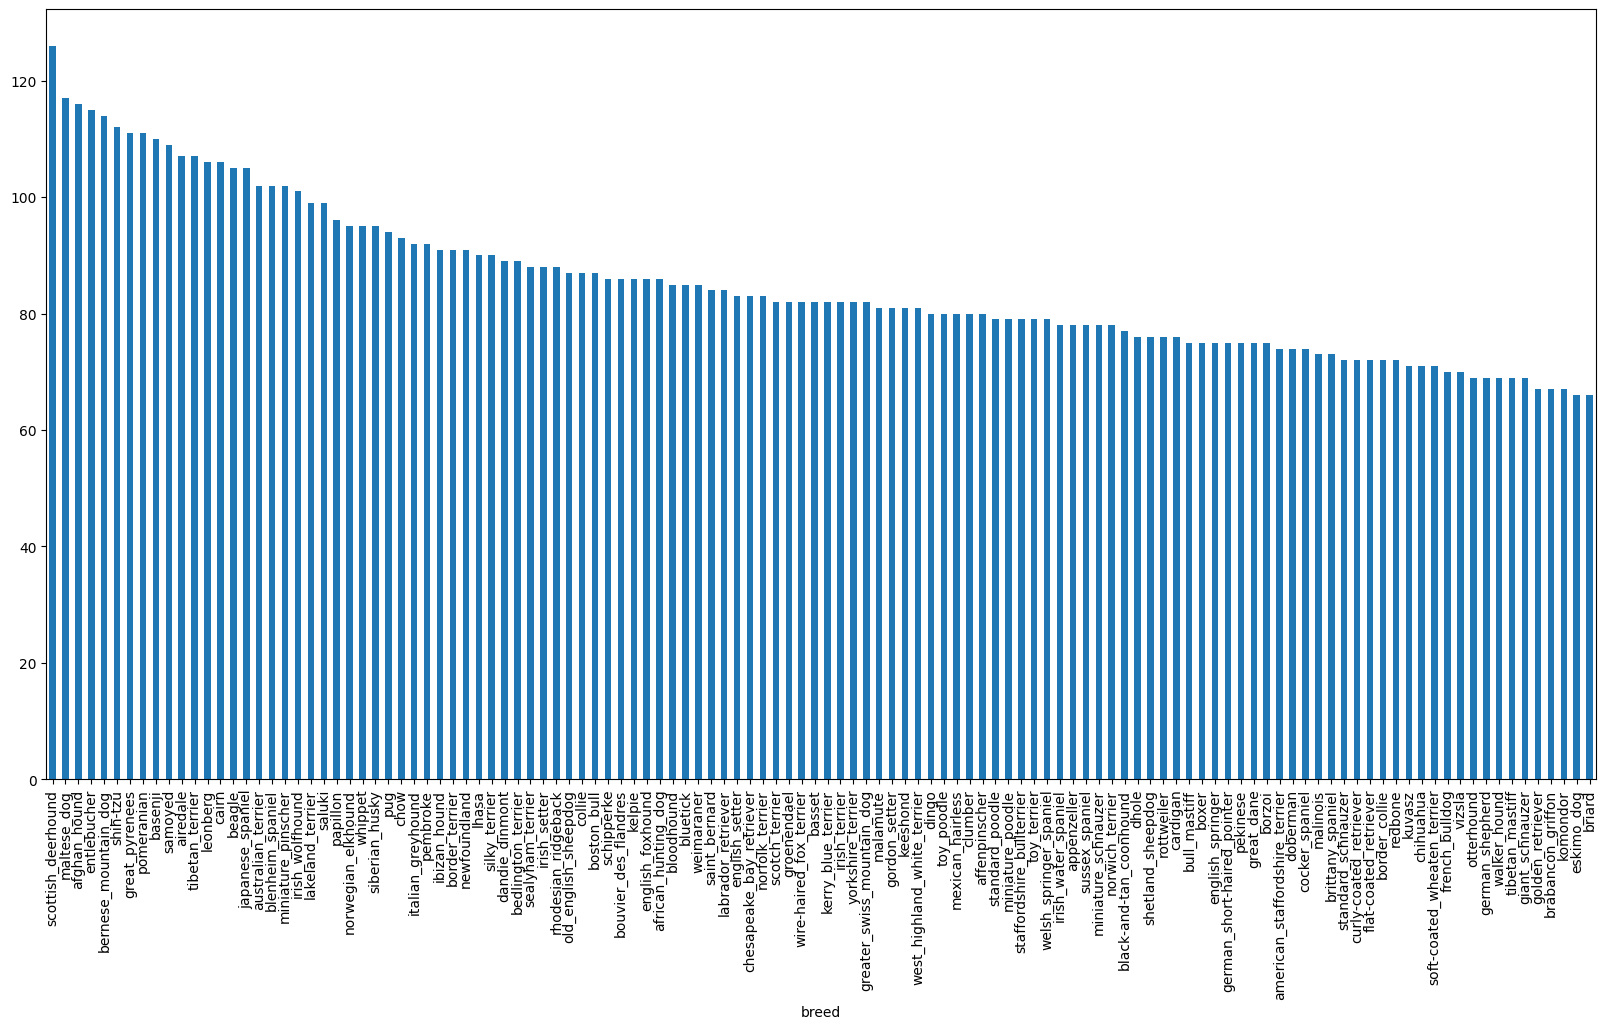

In [7]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

In [8]:
labels_csv['breed'].value_counts().median()

82.0

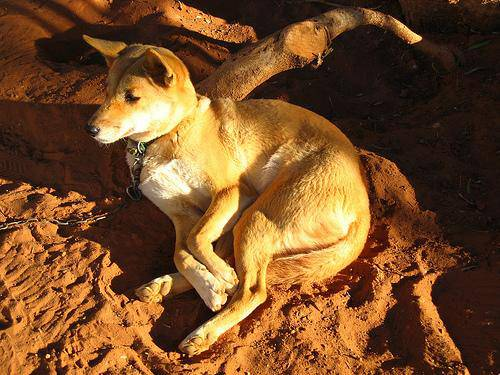

In [9]:
# Let's view an image
from IPython.display import Image
Image('data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

# Getting images and their labels

Let's get a list of all of our image file pathnames.

In [10]:
# Create pathnames from image IDs
filenames = ["data/train/" + fname for fname in labels_csv['id'] + ".jpg"]

# Check the first 10 filenames
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
import os
os.listdir("data/train")[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('data/train/')) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")
  

Filenames match actual amount of files!!! Proceed.


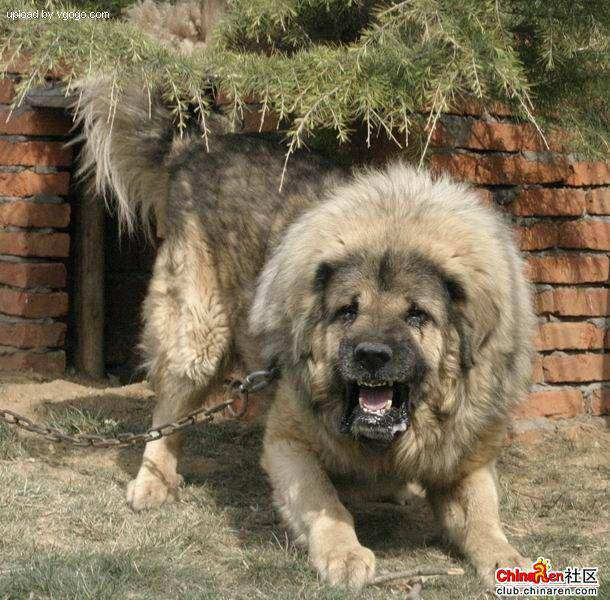

In [13]:
# One more check
Image(filenames[9000])

In [14]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [15]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
len(labels)

10222

In [17]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames


In [18]:
# Find the unique label values
unique_breeds = np.unique(labels) 
len(unique_breeds)

120

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into a boolean array
boolean_labels = [labels == unique_breeds for labels in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset doesn't come with a validation set, we're going to create one.

In [23]:
# Setup X & y variables
x = filenames
y = boolean_labels



We're going to start off experimenting with ~1000 images and increase as needed.

In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [25]:
# Let's split our data into training and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [26]:
# Let's have a geez at the training data
x_train[:5], y_train[:2]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocess images (convert to tensors)
To preprocess our images (converting them into tensors), we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our image (a jpg) into Tensors
4. Resize the image to be of shape (224, 224)
5. Return the modified image


In [27]:
# Convert images to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(), image.min()

(255, 0)

In [29]:
# convert the image into tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

In [30]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """

    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

## Turn our data into batches
Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we use batches.

Batches are subsets of data you'd like to pass into your model at once.

In [31]:
## Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label


In [32]:
# Demo of our image processing function
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of tensors in the form: (`image`, `label`), it's time to make a function to turn these into batches.

In [33]:
# Define the batch size, 32 is a good start
BATCH_SIZE  = 32

# Create a function to turn data into batches
def create_data_batches(x, y= None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print("Creating training data batches...")
        # Turn file paths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        
    return data_batch

In [34]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualize the data batches

Our data is now in batches, however, these can be a lititle hard to understand/comprehend at first. Let's visualize them.

In [36]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """

    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create suplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")


In [37]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

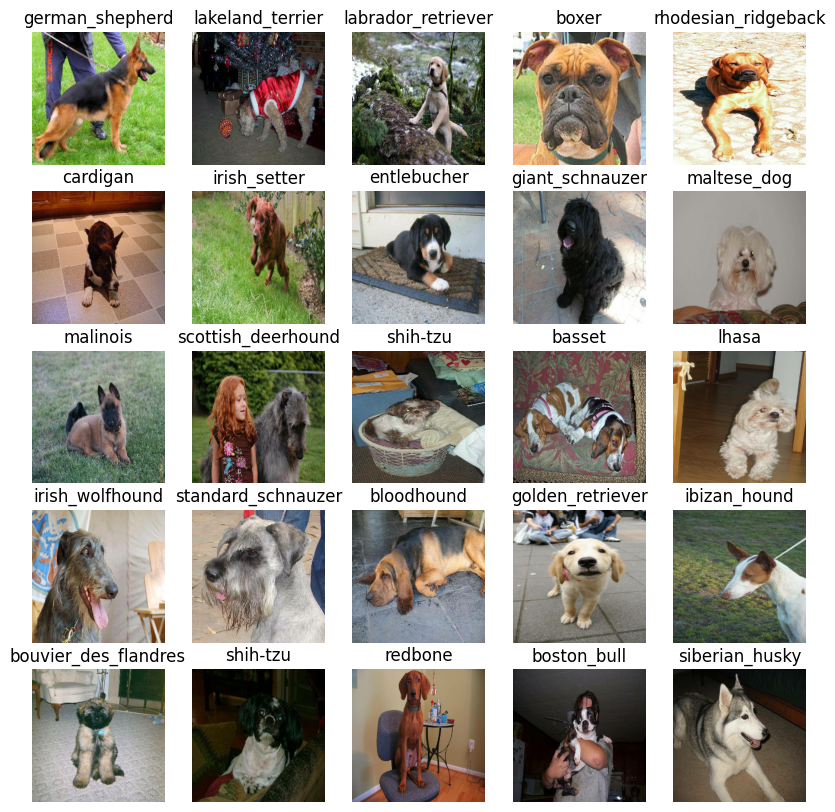

In [38]:
# Now let's visualize the data in a training batch
train_images, train_lables = next(train_data.as_numpy_iterator())
len(train_images), len(train_lables)
show_25_images(train_images, train_lables)

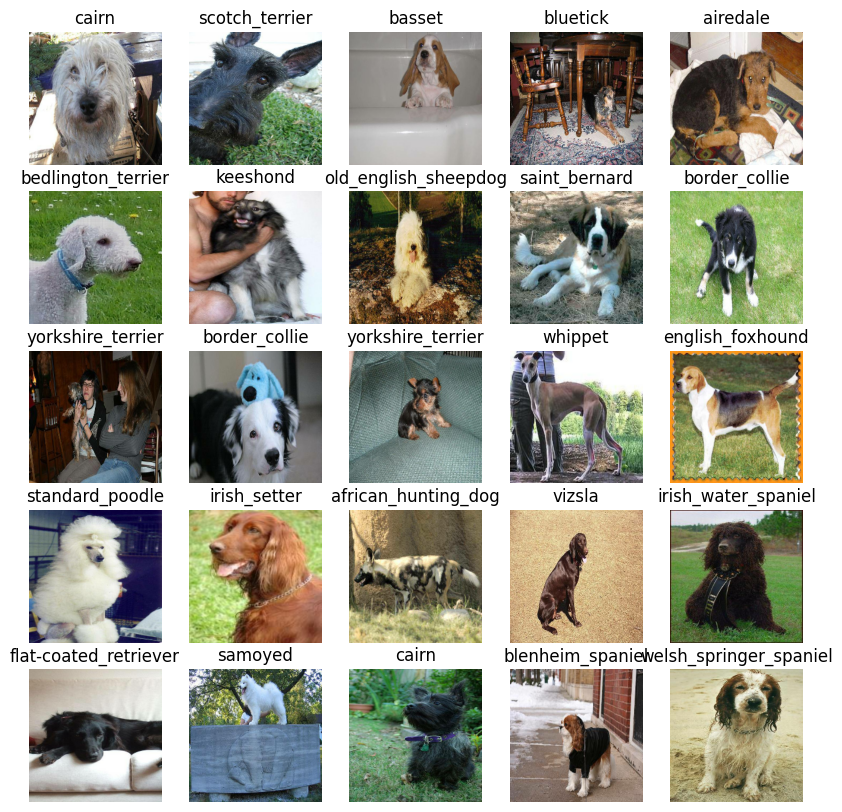

In [39]:
# Now let's visualize the data in a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Buliding a model
Before we build a model, there are a few concepts we have to understand:
* The input shape (the shape of our input data, in this case, the shape of our images).
* The output shape (the shape of our prediction labels, in this case, the shape of our one-hot encoded labels).
* The URL of the model we want to use (in this case, EfficientNetB0 from TensorFlow Hub).

In [40]:
# Setup input shape to the model
INPUT_SHAPE =  [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

#MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

Now we've got our input, output and model ready to go, let's put them together into a Keras deep learning model.

Knowing this, we can use the Keras Functional API to create our model.
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential function(do this first then this then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

In [41]:
TF_USE_LEGACY_KERAS=1

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, ouput_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                              activation='softmax')(x) # Layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Build the model
    model.biuld(input_shape=INPUT_SHAPE[:1])

    return model

In [42]:
from tensorflow.keras.models import Sequential

def create_model_2(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building model...")
    # Setup the base of the model
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE[1:])
    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Sequential([
        Dense(512, activation='relu'),
        Dense(256, activation='relu')
    ])(x)
    outputs = Dense(OUTPUT_SHAPE, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model




In [43]:

model = create_model_2()
model.summary()

Building model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,076,024 (11.73 MB)

 Trainable params: 818,040 (3.12 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
outputs = np.ones(shape=(1, 1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

### Creating callbacks

We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

#### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [45]:
# Loas the TensorBoard notebook extension
%load_ext tensorboard

In [47]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)


#### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [48]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

### Training a model (on a subset of data)
Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

Along with this, let's quickly check if we're still using a GPU.

In [49]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Boom! We've got a GPU running and `NUM_EPOCHS` setup. Let's create a simple function which trains a model. The function will:
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [50]:
def train_model():
    """
    Trains a given model and returns the trained version. 
    """
    # Create a model
    model = create_model_2()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])

    return model

In [51]:
# Fit the model to the data
model = train_model()

Building model...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 895ms/step - accuracy: 0.0355 - loss: 4.8465 - val_accuracy: 0.1450 - val_loss: 4.2156
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 817ms/step - accuracy: 0.2746 - loss: 3.4537 - val_accuracy: 0.3450 - val_loss: 3.0366
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 802ms/step - accuracy: 0.5588 - loss: 1.8486 - val_accuracy: 0.4600 - val_loss: 2.2074
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 799ms/step - accuracy: 0.7528 - loss: 0.9283 - val_accuracy: 0.5550 - val_loss: 1.9822
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 809ms/step - accuracy: 0.8146 - loss: 0.6067 - val_accuracy: 0.5550 - val_loss: 1.8154
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 800ms/step - accuracy: 0.8901 - loss: 0.4049 - val_accuracy: 0.5850 - val_loss: 1.7019
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 813ms/step - accuracy: 0.9328 - loss: 0.2712 - val_accuracy: 0.5700 - val_loss: 1.6676
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 796ms/step - accuracy: 0.9430

#### Checking the TensorBoard logs
Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [54]:
%tensorboard --logdir /logs

Reusing TensorBoard on port 6006 (pid 6156), started 0:01:25 ago. (Use '!kill 6156' to kill it.)